# Dataset Analysis
In this Jupyter Notebook, we analyse dataset from Airbus Ship Detection Challenge.
Main task in this challenge it's "find ships on satellite images as quickly as possible"

In [48]:
# Import requirement libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import random
import os

# Finding how many images we have
num_train_images = len(os.listdir('dataset/train_v2'))
num_test_images = len(os.listdir('dataset/test_v2'))
print(f'Number of images for training: {num_train_images}')
print(f'Number of images for testing: {num_test_images}')

Number of images for training: 192556
Number of images for testing: 15606


In [49]:
# Make function for viewing a random image
def view_random_image(target_dir, target_type):
    # Setup target directory
    target_folder = target_dir+target_type

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read the image and plot it
    img = mpimg.imread(target_folder + "\\" + random_image[0])
    plt.imshow(img)
    plt.title(random_image)
    plt.axis('off')

    # show the shape of the image
    print(f"Image shape: {img.shape}")

    # returning image
    return img

Image shape: (768, 768, 3)


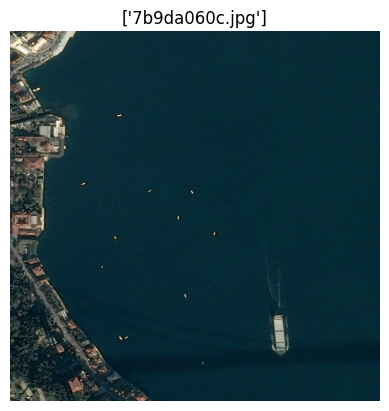

In [50]:
# View a random image from the training dataset
img = view_random_image(target_dir='dataset\\',
                        target_type='train_v2')

In [51]:
# View the tensor of image
img

array([[[ 42,  57,  52],
        [100, 115, 108],
        [ 94, 105,  99],
        ...,
        [  3,  43,  53],
        [  2,  42,  52],
        [  2,  42,  52]],

       [[ 20,  32,  28],
        [ 37,  50,  43],
        [ 87,  98,  90],
        ...,
        [  3,  43,  53],
        [  1,  41,  51],
        [  0,  40,  50]],

       [[ 12,  23,  17],
        [ 15,  26,  20],
        [ 68,  79,  71],
        ...,
        [  7,  47,  57],
        [  6,  46,  56],
        [  3,  43,  53]],

       ...,

       [[124, 127, 118],
        [ 43,  46,  37],
        [ 23,  26,  19],
        ...,
        [  8,  41,  56],
        [  1,  34,  49],
        [  4,  37,  52]],

       [[ 45,  48,  39],
        [ 17,  20,  11],
        [ 31,  37,  27],
        ...,
        [  7,  40,  55],
        [  2,  35,  50],
        [  5,  38,  53]],

       [[174, 177, 168],
        [170, 173, 164],
        [158, 164, 154],
        ...,
        [ 10,  43,  58],
        [  6,  39,  54],
        [  9,  42,  57]]

In [52]:
# View the image shape
img.shape  # returns ( width, height, colour channels)

(768, 768, 3)

In [53]:
# Get all the pixel values between 0 & 1 (normalization)
img/255.

array([[[0.16470588, 0.22352941, 0.20392157],
        [0.39215686, 0.45098039, 0.42352941],
        [0.36862745, 0.41176471, 0.38823529],
        ...,
        [0.01176471, 0.16862745, 0.20784314],
        [0.00784314, 0.16470588, 0.20392157],
        [0.00784314, 0.16470588, 0.20392157]],

       [[0.07843137, 0.1254902 , 0.10980392],
        [0.14509804, 0.19607843, 0.16862745],
        [0.34117647, 0.38431373, 0.35294118],
        ...,
        [0.01176471, 0.16862745, 0.20784314],
        [0.00392157, 0.16078431, 0.2       ],
        [0.        , 0.15686275, 0.19607843]],

       [[0.04705882, 0.09019608, 0.06666667],
        [0.05882353, 0.10196078, 0.07843137],
        [0.26666667, 0.30980392, 0.27843137],
        ...,
        [0.02745098, 0.18431373, 0.22352941],
        [0.02352941, 0.18039216, 0.21960784],
        [0.01176471, 0.16862745, 0.20784314]],

       ...,

       [[0.48627451, 0.49803922, 0.4627451 ],
        [0.16862745, 0.18039216, 0.14509804],
        [0.09019608, 0

In [54]:
# # Check the *.csv files to use that later
# load train_ship_segmentations_v2.csv to pandas DataFrame
train_ground_truth = pd.read_csv("dataset\\train_ship_segmentations_v2.csv")
print(train_ground_truth.head())
num_masks = train_ground_truth.shape[0]
print(num_masks)

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
231723


In [55]:
# load submission.csv to pandas DataFrame
submission = pd.read_csv("dataset\\sample_submission_v2.csv")
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [56]:
train_ground_truth.ImageId[2]

'000155de5.jpg'

In [57]:
train_ground_truth.EncodedPixels[2]

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [58]:
rle_tensor = tf.strings.to_number(tf.strings.split(train_ground_truth.EncodedPixels[2]), tf.int64)
rle_tensor

<tf.Tensor: shape=(208,), dtype=int64, numpy=
array([264661,     17, 265429,     33, 266197,     33, 266965,     33,
       267733,     33, 268501,     33, 269269,     33, 270037,     33,
       270805,     33, 271573,     33, 272341,     33, 273109,     33,
       273877,     33, 274645,     33, 275413,     33, 276181,     33,
       276949,     33, 277716,     34, 278484,     34, 279252,     33,
       280020,     33, 280788,     33, 281556,     33, 282324,     33,
       283092,     33, 283860,     33, 284628,     33, 285396,     33,
       286164,     33, 286932,     33, 287700,     33, 288468,     33,
       289236,     33, 290004,     33, 290772,     33, 291540,     33,
       292308,     33, 293076,     33, 293844,     33, 294612,     33,
       295380,     33, 296148,     33, 296916,     33, 297684,     33,
       298452,     33, 299220,     33, 299988,     33, 300756,     33,
       301524,     33, 302292,     33, 303060,     33, 303827,     34,
       304595,     34, 305363, 

In [59]:
rle_tensor[::2]

<tf.Tensor: shape=(104,), dtype=int64, numpy=
array([264661, 265429, 266197, 266965, 267733, 268501, 269269, 270037,
       270805, 271573, 272341, 273109, 273877, 274645, 275413, 276181,
       276949, 277716, 278484, 279252, 280020, 280788, 281556, 282324,
       283092, 283860, 284628, 285396, 286164, 286932, 287700, 288468,
       289236, 290004, 290772, 291540, 292308, 293076, 293844, 294612,
       295380, 296148, 296916, 297684, 298452, 299220, 299988, 300756,
       301524, 302292, 303060, 303827, 304595, 305363, 306131, 306899,
       307667, 308435, 309203, 309971, 310739, 311507, 312275, 313043,
       313811, 314579, 315347, 316115, 316883, 317651, 318419, 319187,
       319955, 320723, 321491, 322259, 323027, 323795, 324563, 325331,
       326099, 326867, 327635, 328403, 329171, 329938, 330706, 331474,
       332242, 333010, 333778, 334546, 335314, 336082, 336850, 337618,
       338386, 339154, 339922, 340690, 341458, 342226, 343003, 343787],
      dtype=int64)>

In [60]:
rle_tensor[1::2]

<tf.Tensor: shape=(104,), dtype=int64, numpy=
array([17, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       24,  8], dtype=int64)>

In [61]:
# create function for decoding run-length mask from "train_ship_segmentations_v2.csv"
def tf_rle_decode(rle_string, shape=(768, 768)):
    """
    Function for decoding run-length encoding mask from string.

    :param rle_string: run-length string from csv file
    :param shape: shape of output image
    :return: tensor as image mask
    """
    shape_tensor = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)

    rle_tensor = tf.strings.split(rle_string)
    rle_tensor = tf.strings.to_number(rle_tensor, tf.int64)

    starts = rle_tensor[::2] - 1
    lengths = rle_tensor[1::2]

    # Make ones to be scattered
    total_ones = tf.reduce_sum(lengths)
    ones = tf.ones([total_ones], tf.uint8)

    # Make scattering indices
    ones_range = tf.range(total_ones)
    lens_cumsum = tf.math.cumsum(lengths)
    rle_ssorted = tf.searchsorted(lens_cumsum, ones_range, 'right')
    idx = ones_range + tf.gather(starts - tf.pad(lens_cumsum[:-1], [(1, 0)]), rle_ssorted)

    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])

    # Reshape into mask
    return tf.reshape(mask_flat, shape_tensor)

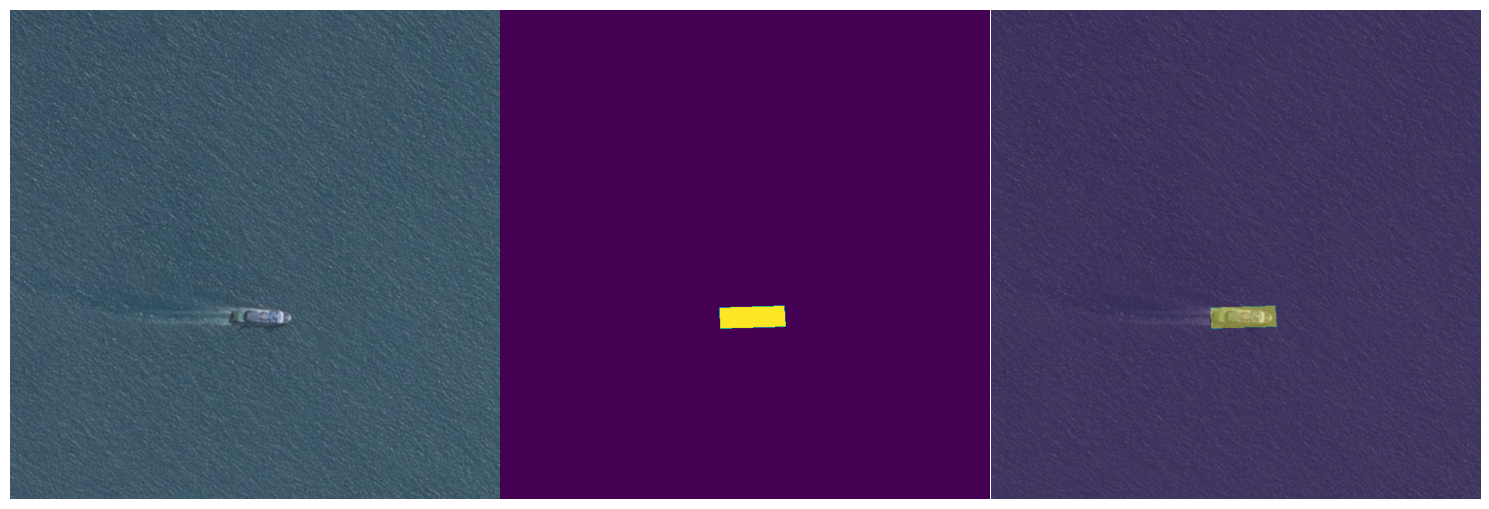

In [62]:
# Set image id that we check with his mask
image_id = '000155de5.jpg'

# Read image from directory
image = cv2.cvtColor(cv2.imread('dataset\\train_v2\\' + image_id), cv2.COLOR_BGR2RGB)
# make a list with the masks that image_id match
image_masks = train_ground_truth.loc[train_ground_truth['ImageId'] == image_id, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = tf.zeros((768, 768), tf.uint8)
for mask in image_masks:
    all_masks += tf.transpose(tf_rle_decode(mask))

# Create plot with 3 different sight of image (with masks)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(image)
axarr[1].imshow(all_masks)
axarr[2].imshow(image)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()